Note: *cudamat* is one option to do parallel computing for matrix computation

In [2]:
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.io import loadmat
import random
from numpy import linalg as LA
import time
from fun1d import *
from IPython import display
# from numbapro import vectorize

In [3]:
def synthesis(sx, psi_hat, psi, jacob, max_err, max_epoch, z, *args):
    # collect parameters
    nx = psi_hat.shape[0]
    nw = psi_hat.shape[1]  # number of wavelets 
    
    # randomly initialize new signal
    narg = len(args)
    if narg == 0:
        y0 = np.random.random(nx) 
    else:
        y0 = args[0]
        
    y = np.zeros((nx, 1))
    
    err = 1
    epoch = 0
    tic = time.time()
    while (epoch < max_epoch):
        
        epoch += 1
        ind = np.random.choice(nw, nw, replace = False) # randomize index of wavelets
        print('epoch:', epoch)
        
        for i in range(nw):
#             print('number of wavelets:', i + 1)
#             print('added index:', ind[i])
            if jacob:
                res = minimize(diff, y0, args = (sx[np.append([0], ind[0:i+1] + 1)], psi_hat[:,ind[0:i+1]], \
                                                         psi[:,ind[0:i+1]], z), jac = jac, method='BFGS')
            else:
                res = minimize(diff, y0, args = (sx[np.append([0], ind[0:i+1] + 1)], psi_hat[:,ind[0:i+1]], \
                                                         psi[:,ind[0:i+1]], z), method='BFGS')
            y0 = res.x
            y = np.append(y, np.reshape(y0, (y0.shape[0], 1)), axis = 1)
            
            err = res.fun
            print('current error:', err)
        
    toc = time.time()
    print('running time: ', toc - tic)
    return y


In [59]:
n = 1024
l = 0.01
pi = math.pi
max_err = 1e-7
max_epoch = 3
jacob = True
z = False
nsample = 5000
epsilon = 1e-4

# define filters
sigma = determine_sigma(epsilon)
Q = 0.5
alpha = 2
J = determine_J(n, Q, sigma, alpha)
s = np.unique(np.floor(2 ** np.linspace(0, J, int(J/Q)+1)))
xi = 2 * pi * np.random.choice(n,1) / n
g, g_hat = window_filter_family_1d(n, s, xi, sigma)
g = np.reshape(g, (g.shape[0], -1))
g_hat = np.reshape(g_hat, (g_hat.shape[0], -1))

t = np.linspace(0, n + 1, n + 1)
y = sample_poisson(t, l)[0]
dy = np.diff(y)
sx1 = np.sum(np.abs(wave_trans_in_freq_1d(dy, g_hat)), axis = 0)
# sx = np.append(np.sum(dy), sx)

# sx = prod_f(g_hat, t, nsample, l)

In [60]:
sx1

array([0.01171868, 0.02337586, 0.04591485, 0.05670233, 0.08709784,
       0.11528196, 0.15708137, 0.19852061, 0.25218911, 0.31651677,
       0.41640761, 0.55024232, 0.72044414])

In [56]:
sx

array([0.00981072, 0.00993199, 0.01947403, 0.01979882, 0.03765682,
       0.03792199, 0.04630993, 0.04646881, 0.07102977, 0.07089729,
       0.09428012, 0.09400739, 0.13031957, 0.13000175, 0.16951344,
       0.16891641, 0.22568632, 0.22477221, 0.28567221, 0.28481702,
       0.3561872 , 0.35581988, 0.43291212, 0.43314535, 0.52218717,
       0.52283802])

In [6]:
res = synthesis(sx, g_hat, g, jacob, max_err, max_epoch, z)

epoch: 1
current error: 1.3511720204082664e-11


KeyboardInterrupt: 

In [69]:
# load results synthesized by previous optimization method(add one wavelet each optimization)
res1 = np.load('res_poisson5.npy')
# g_hat1 = np.load('g_hat3.npy')
sx = np.load('f5.npy')


In [70]:
res1.shape
sx.shape

(14,)

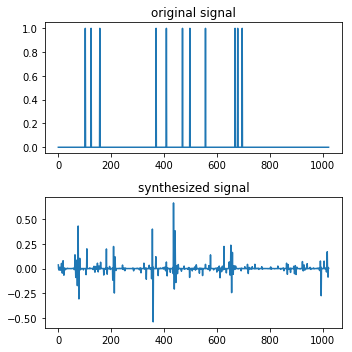

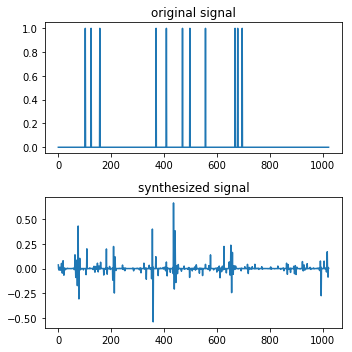

In [71]:
fig = plt.figure()
plt.figure(figsize = (5,5))
plt.subplot(2,1,1)
plt.plot(res1[:, 0]) # target signal
plt.title('original signal')
ax2 = plt.subplot(2,1,2)
for i in range(res1.shape[1] - 1):
    ax2.clear()
    ax2.plot(res1[:, i+1]) # synthesized signal from each iteration
    ax2.set_title('synthesized signal')
    print(i)
    plt.tight_layout()
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.5)
    
# fig = plt.figure()
# plt.figure(figsize = (5,5))
# plt.subplot(2,1,1)
# plt.plot(res1[:, 0]) # target signal
# plt.title('original signal')
# ax2 = plt.subplot(2,1,2)
# plt.plot(res1[:, -1])
# plt.title('synthesized signal')

In [72]:
sigma = determine_sigma(epsilon)
Q = 2
alpha = 2
J = determine_J(n, Q, sigma, alpha)
s = np.unique(np.floor(2 ** np.linspace(0, J, int(J*Q)+1)))
xi = np.arange(1,2) * pi / 3
g, g_hat = window_filter_family_1d(n, s, xi, sigma)
g = np.reshape(g, (g.shape[0], -1))
g_hat = np.reshape(g_hat, (g_hat.shape[0], -1))

In [73]:
y0 = res1[:,-1]
x = res1[:,0]
sy = np.sum(np.abs(wave_trans_in_freq_1d(y0, g_hat)), axis = 0)
# sx = np.sum(np.abs(wave_trans_in_freq_1d(res1[:,0], g_hat1)), axis = 0)
print('scattering difference with wavelets in optimization process:', np.sum((sx - sy)**2))

scattering difference with wavelets in optimization process: 2.652233139883421e-15


Text(0.5,1,'result for xi_2')

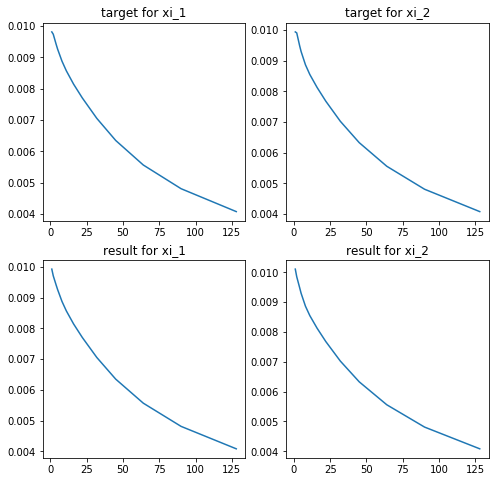

In [46]:
plt.figure(figsize = (8,8))
ind = np.arange(13)*2 

plt.subplot(2,2,1)
plt.plot(s, np.divide(sx[ind], s))
plt.title('target for xi_1')
plt.subplot(2,2,2)
plt.plot(s, np.divide(sx[ind+1],s))
plt.title('target for xi_2')
plt.subplot(2,2,3)
plt.plot(s, np.divide(sy[ind], s))
plt.title('result for xi_1')
plt.subplot(2,2,4)
plt.plot(s, np.divide(sy[ind+1], s))
plt.title('result for xi_2')

In [74]:
sx.shape

(14,)

In [75]:
s.shape

(14,)

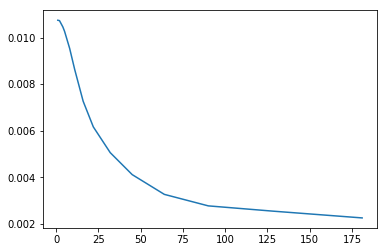

In [78]:
plt.figure()
plt.plot(s, np.divide(sy/n, s))

In [39]:
b = np.reshape(a, (a.shape[0],-1))

In [40]:
a

array([[[0, 1, 2],
        [3, 4, 5]]])

In [41]:
b

array([[0, 1, 2, 3, 4, 5]])